# Architecture
### Encoder:
Input: $x_t$ (batch_size, input_dim), $z_prev$ (batch_size, latent_dim)
Output: $mu_z$ (batch_size, latent_dim), $logvar_z$ (batch_size, latent_dim)

The encoder takes the input sequence $X_{1:T}$ and the previous latent variable $z_{1:t-1}$ as inputs and outputs mean and log-variance of the posterior distribution of the latent variables.

### Decoder:
Input: $z_t$ (batch_size, latent_dim)
Output: reconstucted $x_t$ (batch_size, input_dim)

The decoder takes the current latent variable $z_t$ as input and outputs the reconstructed input $x_t$.

### Prior Network:
Input: $z_{prev}$ (batch_size, latent_dim)
Output: $mu_{prior}$ (batch_size, latent_dim), $logvar_{prior}$ (batch_size, latent_dim)

The prior network takes the previous latent variable $z_{1:t-1}$ as input and outputs mean and log-variance of the prior distribution for the current time step.

# Data and main parameters

In [1]:
import math
from tqdm.auto import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = 'datasets/'
!git clone https://github.com/lqwic/deep_var.git
%cd deep_var/

Cloning into 'deep_var'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 50 (delta 10), reused 18 (delta 6), pack-reused 25
Receiving objects: 100% (50/50), 23.32 MiB | 9.61 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (9/9), done.
/content/deep_var


In [3]:
def load_data(file_path):
    return pd.read_csv(file_path, index_col='Date', parse_dates=True)

stocks = load_data(data_path + 'stocks.csv')
commodities = load_data(data_path + 'commodities.csv')
crypto = load_data(data_path + 'cryptos.csv')

window_size = 21
alpha = 99
train_size = 0.8
data = crypto

# Model

In [114]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.encoder_gru = nn.GRU(input_dim + latent_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.encoder_mu = nn.Linear(2 * hidden_dim, latent_dim)
        self.encoder_logvar = nn.Linear(2 * hidden_dim, latent_dim)

    def forward(self, x, z_prev):
        _, h_n = self.encoder_gru(torch.cat([x, z_prev], dim=-1))
        h_n = torch.cat([h_n[-2], h_n[-1]], dim=-1)
        mu = self.encoder_mu(h_n)
        logvar = self.encoder_logvar(h_n)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.decoder_gru = nn.GRU(latent_dim, hidden_dim, batch_first=True)
        self.decoder_fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, seq_len):
        output, _ = self.decoder_gru(z)
        output = output.contiguous().view(-1, self.hidden_dim)
        x_recon = self.decoder_fc(output)
        x_recon = x_recon.view(-1, seq_len, self.output_dim)
        return x_recon

class PriorNetwork(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super(PriorNetwork, self).__init__()
        self.hidden_dim = hidden_dim

        self.prior_gru = nn.GRU(latent_dim, hidden_dim, batch_first=True)
        self.prior_mu = nn.Linear(hidden_dim, latent_dim)
        self.prior_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, z_prev):
        _, h_n = self.prior_gru(z_prev)
        prior_mu = self.prior_mu(h_n.squeeze(0))
        prior_logvar = self.prior_logvar(h_n.squeeze(0))
        return prior_mu, prior_logvar

class TempVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super(TempVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)
        self.prior_network = PriorNetwork(latent_dim, hidden_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        seq_len = x.size(1)
        batch_size = x.size(0)

        z_prev = torch.zeros(batch_size, 1, self.latent_dim).to(x.device)
        z_mu_seq = []
        z_logvar_seq = []

        for t in range(seq_len):
            x_t = x[:, t, :].unsqueeze(1)
            mu_z, logvar_z = self.encoder(x_t, z_prev)
            z_t = self.reparameterize(mu_z, logvar_z)

            z_mu_seq.append(mu_z)
            z_logvar_seq.append(logvar_z)

            z_prev = z_t.unsqueeze(1)

        z_mu = torch.stack(z_mu_seq, dim=1)
        z_logvar = torch.stack(z_logvar_seq, dim=1)

        z = self.reparameterize(z_mu, z_logvar)
        x_recon = self.decoder(z, seq_len)

        return x_recon, z_mu, z_logvar

# Training

In [115]:
from torch.utils.data import DataLoader, TensorDataset

def preprocess_data(data, seq_length=21, train_ratio=0.66):
    data = data.values
    data = (data - data.mean(axis=0)) / data.std(axis=0)

    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i+seq_length])

    sequences = torch.tensor(sequences, dtype=torch.float32)
    train_size = int(train_ratio * len(sequences))
    train_data = sequences[:train_size]
    test_data = sequences[train_size - seq_length:]

    train_dataset = TensorDataset(train_data)
    test_dataset = TensorDataset(test_data)

    return train_dataset, test_dataset

def train(model, train_loader, optimizer, beta=1.0, lambda_reg=0.001, device=torch.device('cpu')):
    model.train()
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0
    train_l2_loss = 0

    for batch in train_loader:
        batch = batch[0].to(device)
        optimizer.zero_grad()
        recon_batch, z_mu, z_logvar = model(batch)
        recon_loss = nn.MSELoss(reduction='sum')(recon_batch, batch)
        kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mu.pow(2) - z_logvar.exp())
        l2_loss = sum(p.pow(2).sum() for p in model.parameters())
        loss = recon_loss + beta * kl_loss + lambda_reg * l2_loss

        loss.backward()
        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()
        train_l2_loss += l2_loss.item()
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    train_recon_loss /= len(train_loader.dataset)
    train_kl_loss /= len(train_loader.dataset)
    train_l2_loss /= len(train_loader.dataset)

    return train_loss, train_recon_loss, train_kl_loss, train_l2_loss

def test(model, test_loader, beta=1.0, lambda_reg=0.001, device=torch.device('cpu')):
    model.eval()
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    test_l2_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            batch = batch[0].to(device)
            recon_batch, z_mu, z_logvar = model(batch)
            recon_loss = nn.MSELoss(reduction='sum')(recon_batch, batch)
            kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mu.pow(2) - z_logvar.exp())
            l2_loss = sum(p.pow(2).sum() for p in model.parameters())
            loss = recon_loss + beta * kl_loss + lambda_reg * l2_loss

            test_loss += loss.item()
            test_recon_loss += recon_loss.item()
            test_kl_loss += kl_loss.item()
            test_l2_loss += l2_loss.item()

    test_loss /= len(test_loader.dataset)
    test_recon_loss /= len(test_loader.dataset)
    test_kl_loss /= len(test_loader.dataset)
    test_l2_loss /= len(test_loader.dataset)

    return test_loss, test_recon_loss, test_kl_loss, test_l2_loss

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [10/1000], Train Loss: 284.1127, Train Recon Loss: 272.2572, Train KL Loss: 35.3705, Train L2 Loss: 0.5286, Test Loss: 96.3727, Test Recon Loss: 86.1882, Test KL Loss: 30.3848, Test L2 Loss: 0.4963
Epoch [20/1000], Train Loss: 238.6252, Train Recon Loss: 215.6300, Train KL Loss: 41.2092, Train L2 Loss: 0.4960, Test Loss: 87.6741, Test Recon Loss: 71.5720, Test KL Loss: 28.8560, Test L2 Loss: 0.4659
Epoch [30/1000], Train Loss: 231.4064, Train Recon Loss: 204.4651, Train KL Loss: 38.1522, Train L2 Loss: 0.4837, Test Loss: 87.0072, Test Recon Loss: 68.6374, Test KL Loss: 26.0136, Test L2 Loss: 0.4559
Epoch [40/1000], Train Loss: 225.4456, Train Recon Loss: 194.9750, Train KL Loss: 37.8683, Train L2 Loss: 0.4934, Test Loss: 85.8184, Test Recon Loss: 65.0330, Test KL Loss: 25.8315, Test L2 Loss: 0.4658
Epoch [50/1000], Train Loss: 219.0409, Train Recon Loss: 187.2508, Train KL Loss: 36.5349, Train L2 Loss: 0.5195, Test Loss: 82.9223, Test Recon Loss: 60.7119, Test KL Loss: 25.5253, T

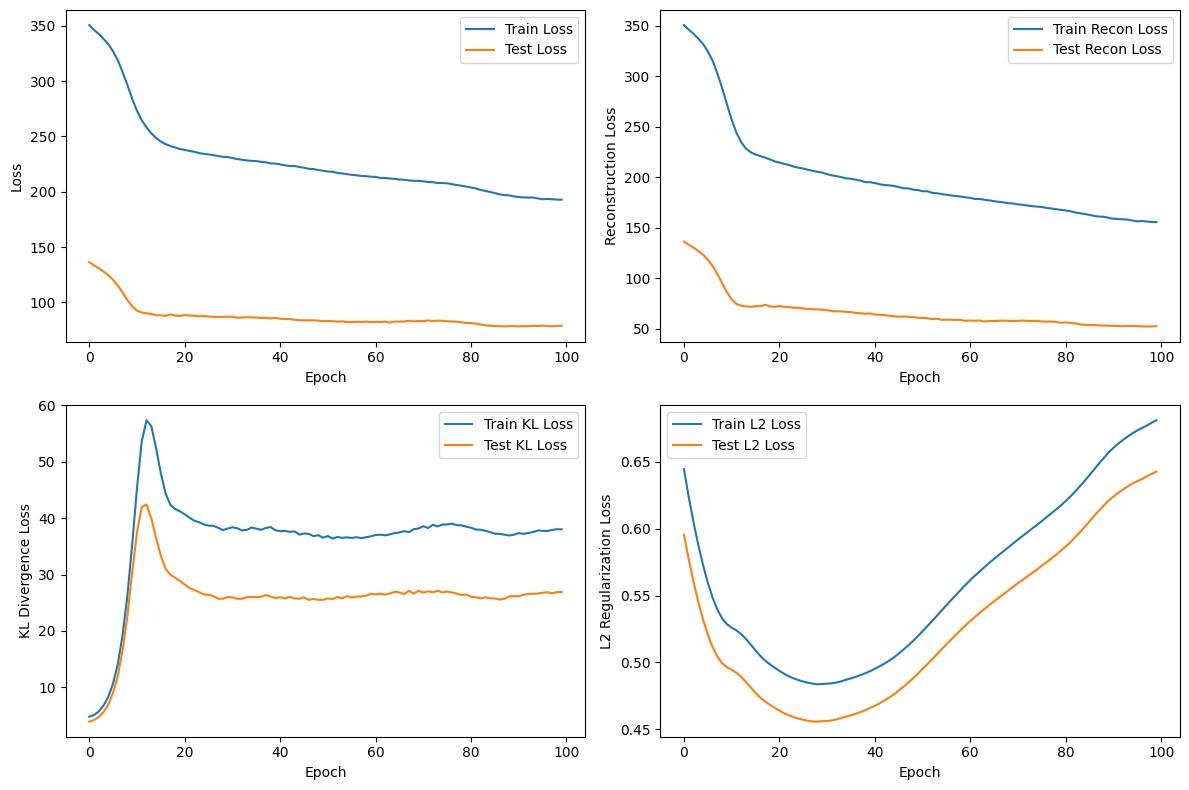

Epoch [110/1000], Train Loss: 190.5495, Train Recon Loss: 151.6678, Train KL Loss: 38.8810, Train L2 Loss: 0.6998, Test Loss: 80.2103, Test Recon Loss: 53.2886, Test KL Loss: 26.9211, Test L2 Loss: 0.6602
Epoch [120/1000], Train Loss: 188.7799, Train Recon Loss: 149.0493, Train KL Loss: 39.7298, Train L2 Loss: 0.7181, Test Loss: 80.7275, Test Recon Loss: 53.6910, Test KL Loss: 27.0358, Test L2 Loss: 0.6776
Epoch [130/1000], Train Loss: 186.6620, Train Recon Loss: 145.8780, Train KL Loss: 40.7833, Train L2 Loss: 0.7377, Test Loss: 81.4347, Test Recon Loss: 53.8826, Test KL Loss: 27.5513, Test L2 Loss: 0.6961
Epoch [140/1000], Train Loss: 184.7341, Train Recon Loss: 143.0152, Train KL Loss: 41.7182, Train L2 Loss: 0.7577, Test Loss: 81.7869, Test Recon Loss: 53.8104, Test KL Loss: 27.9758, Test L2 Loss: 0.7151
Epoch [150/1000], Train Loss: 183.5193, Train Recon Loss: 140.7943, Train KL Loss: 42.7243, Train L2 Loss: 0.7796, Test Loss: 82.5263, Test Recon Loss: 53.7087, Test KL Loss: 28.81

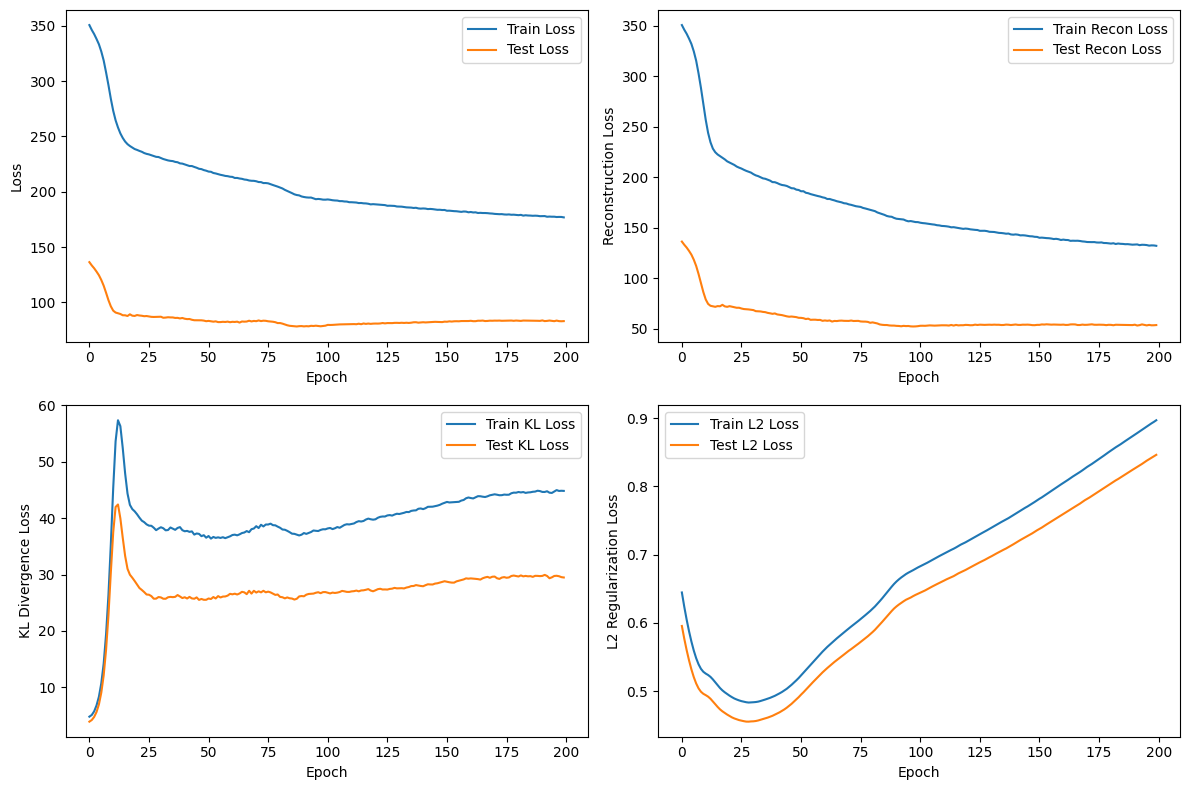

Epoch [210/1000], Train Loss: 176.1130, Train Recon Loss: 131.2191, Train KL Loss: 44.8930, Train L2 Loss: 0.9212, Test Loss: 82.8109, Test Recon Loss: 53.2574, Test KL Loss: 29.5526, Test L2 Loss: 0.8693
Epoch [220/1000], Train Loss: 175.3077, Train Recon Loss: 130.5758, Train KL Loss: 44.7309, Train L2 Loss: 0.9453, Test Loss: 82.7479, Test Recon Loss: 53.2301, Test KL Loss: 29.5169, Test L2 Loss: 0.8922
Epoch [230/1000], Train Loss: 174.6783, Train Recon Loss: 129.6779, Train KL Loss: 44.9995, Train L2 Loss: 0.9705, Test Loss: 82.1071, Test Recon Loss: 52.6534, Test KL Loss: 29.4528, Test L2 Loss: 0.9158
Epoch [240/1000], Train Loss: 173.8137, Train Recon Loss: 128.6701, Train KL Loss: 45.1426, Train L2 Loss: 0.9965, Test Loss: 82.1536, Test Recon Loss: 52.6824, Test KL Loss: 29.4702, Test L2 Loss: 0.9401
Epoch [250/1000], Train Loss: 173.3807, Train Recon Loss: 127.9909, Train KL Loss: 45.3888, Train L2 Loss: 1.0232, Test Loss: 81.9903, Test Recon Loss: 52.3539, Test KL Loss: 29.63

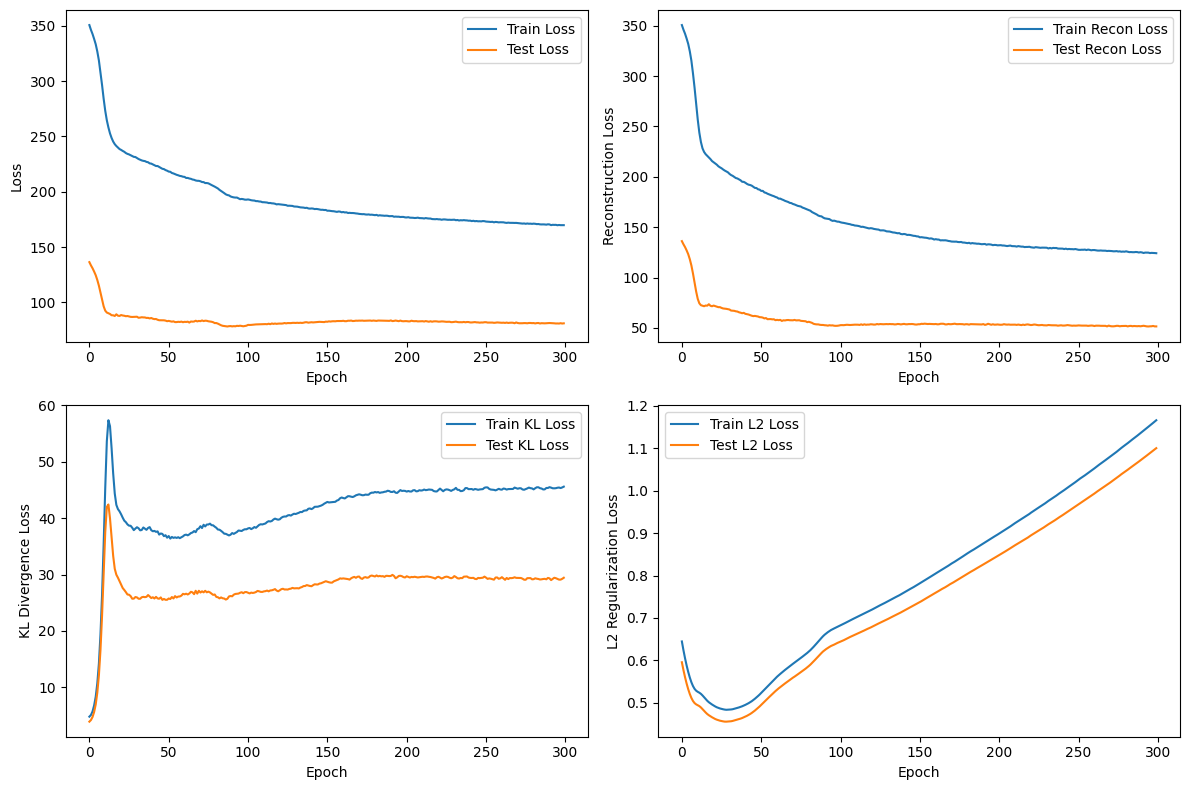

Epoch [310/1000], Train Loss: 168.9259, Train Recon Loss: 123.1632, Train KL Loss: 45.7615, Train L2 Loss: 1.1967, Test Loss: 81.0044, Test Recon Loss: 51.6148, Test KL Loss: 29.3884, Test L2 Loss: 1.1290
Epoch [320/1000], Train Loss: 168.3160, Train Recon Loss: 122.8962, Train KL Loss: 45.4185, Train L2 Loss: 1.2282, Test Loss: 80.2653, Test Recon Loss: 51.1334, Test KL Loss: 29.1308, Test L2 Loss: 1.1590
Epoch [330/1000], Train Loss: 167.3866, Train Recon Loss: 121.7151, Train KL Loss: 45.6702, Train L2 Loss: 1.2598, Test Loss: 80.4831, Test Recon Loss: 51.3440, Test KL Loss: 29.1380, Test L2 Loss: 1.1886
Epoch [340/1000], Train Loss: 166.9409, Train Recon Loss: 121.1801, Train KL Loss: 45.7595, Train L2 Loss: 1.2910, Test Loss: 80.2603, Test Recon Loss: 51.2279, Test KL Loss: 29.0312, Test L2 Loss: 1.2178
Epoch [350/1000], Train Loss: 166.7795, Train Recon Loss: 120.7675, Train KL Loss: 46.0107, Train L2 Loss: 1.3217, Test Loss: 80.5046, Test Recon Loss: 51.1815, Test KL Loss: 29.32

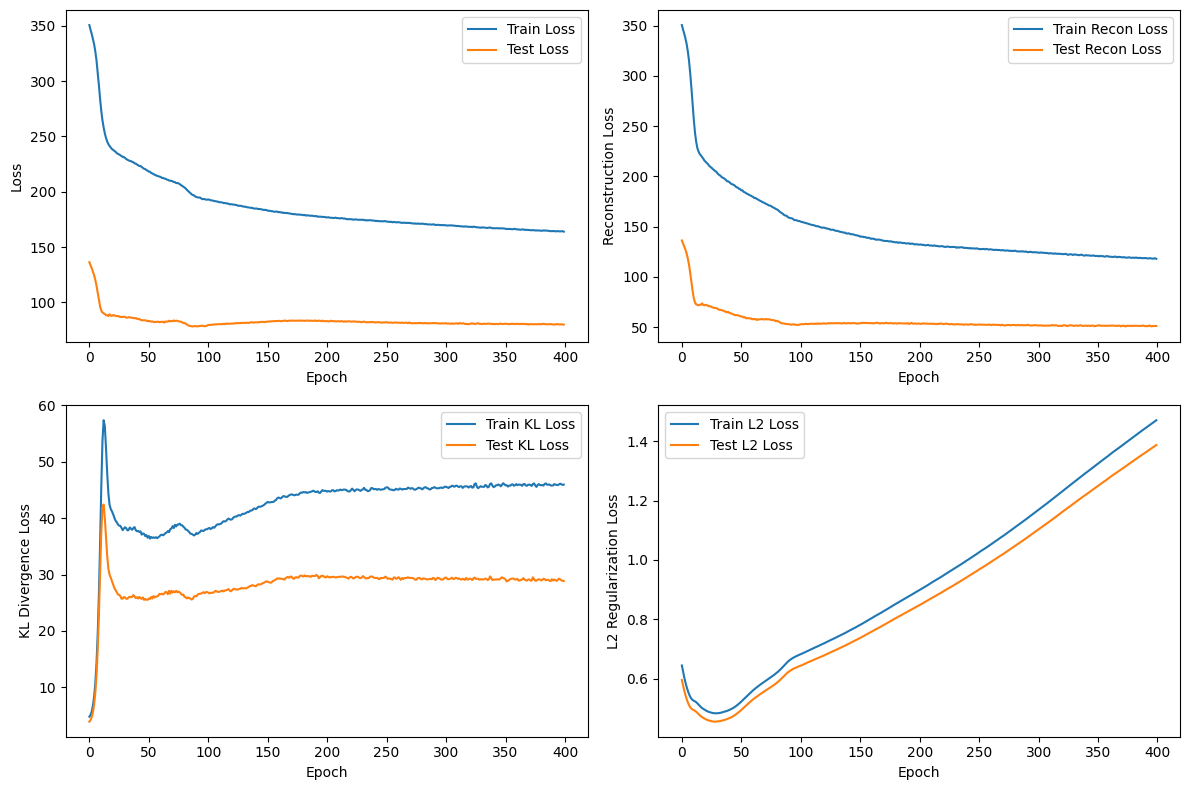

Epoch [410/1000], Train Loss: 163.5074, Train Recon Loss: 117.8243, Train KL Loss: 45.6816, Train L2 Loss: 1.4985, Test Loss: 79.7076, Test Recon Loss: 50.9066, Test KL Loss: 28.7996, Test L2 Loss: 1.4133
Epoch [420/1000], Train Loss: 163.3549, Train Recon Loss: 117.3252, Train KL Loss: 46.0281, Train L2 Loss: 1.5264, Test Loss: 79.6769, Test Recon Loss: 50.8291, Test KL Loss: 28.8464, Test L2 Loss: 1.4397
Epoch [430/1000], Train Loss: 162.9040, Train Recon Loss: 116.9577, Train KL Loss: 45.9447, Train L2 Loss: 1.5531, Test Loss: 79.8276, Test Recon Loss: 51.0385, Test KL Loss: 28.7877, Test L2 Loss: 1.4646
Epoch [440/1000], Train Loss: 162.3467, Train Recon Loss: 116.5500, Train KL Loss: 45.7951, Train L2 Loss: 1.5797, Test Loss: 79.7305, Test Recon Loss: 51.1102, Test KL Loss: 28.6188, Test L2 Loss: 1.4898
Epoch [450/1000], Train Loss: 162.5898, Train Recon Loss: 116.7372, Train KL Loss: 45.8510, Train L2 Loss: 1.6060, Test Loss: 79.8518, Test Recon Loss: 51.2719, Test KL Loss: 28.57

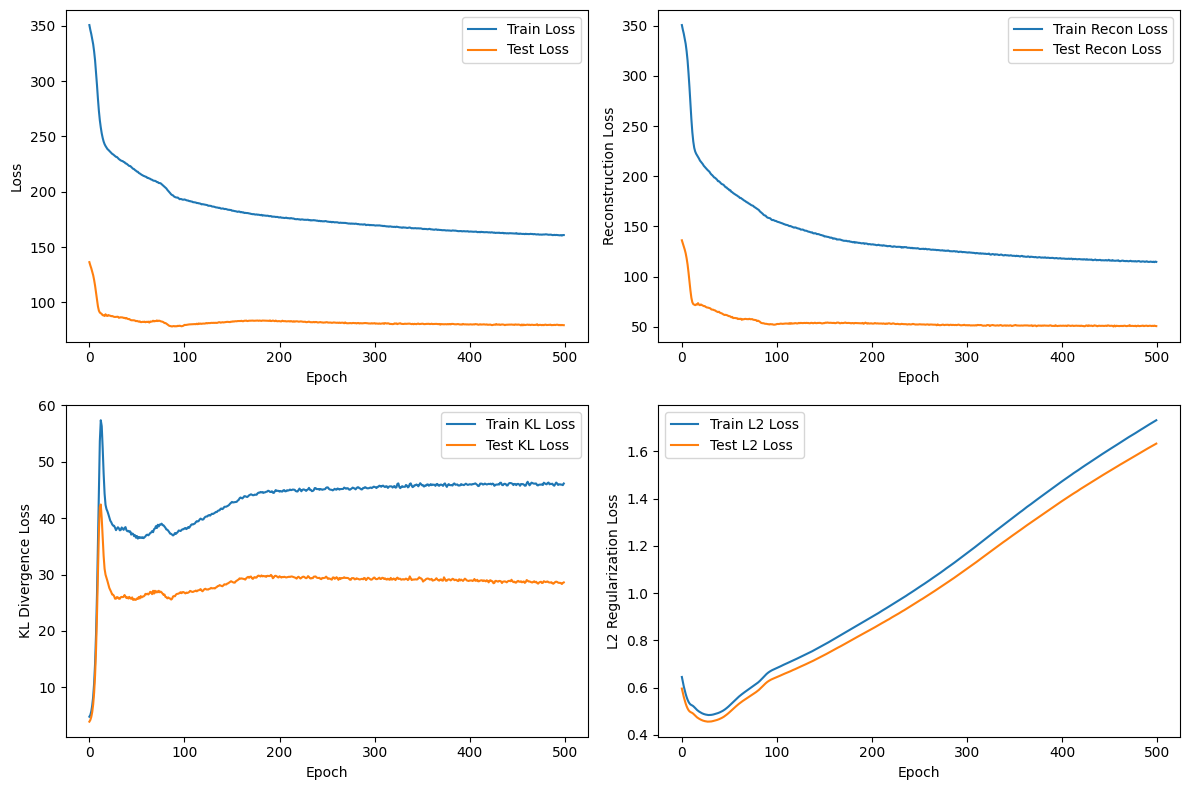

Epoch [510/1000], Train Loss: 160.3698, Train Recon Loss: 114.3733, Train KL Loss: 45.9948, Train L2 Loss: 1.7544, Test Loss: 79.7560, Test Recon Loss: 51.1551, Test KL Loss: 28.5993, Test L2 Loss: 1.6541
Epoch [520/1000], Train Loss: 159.9255, Train Recon Loss: 114.0617, Train KL Loss: 45.8621, Train L2 Loss: 1.7780, Test Loss: 79.4706, Test Recon Loss: 51.1691, Test KL Loss: 28.2999, Test L2 Loss: 1.6763
Epoch [530/1000], Train Loss: 159.9534, Train Recon Loss: 113.8138, Train KL Loss: 46.1378, Train L2 Loss: 1.8008, Test Loss: 79.5488, Test Recon Loss: 51.1320, Test KL Loss: 28.4152, Test L2 Loss: 1.6978
Epoch [540/1000], Train Loss: 159.7355, Train Recon Loss: 113.5727, Train KL Loss: 46.1610, Train L2 Loss: 1.8234, Test Loss: 79.2291, Test Recon Loss: 50.7561, Test KL Loss: 28.4713, Test L2 Loss: 1.7189
Epoch [550/1000], Train Loss: 159.5655, Train Recon Loss: 113.6414, Train KL Loss: 45.9222, Train L2 Loss: 1.8456, Test Loss: 79.1466, Test Recon Loss: 50.7621, Test KL Loss: 28.38

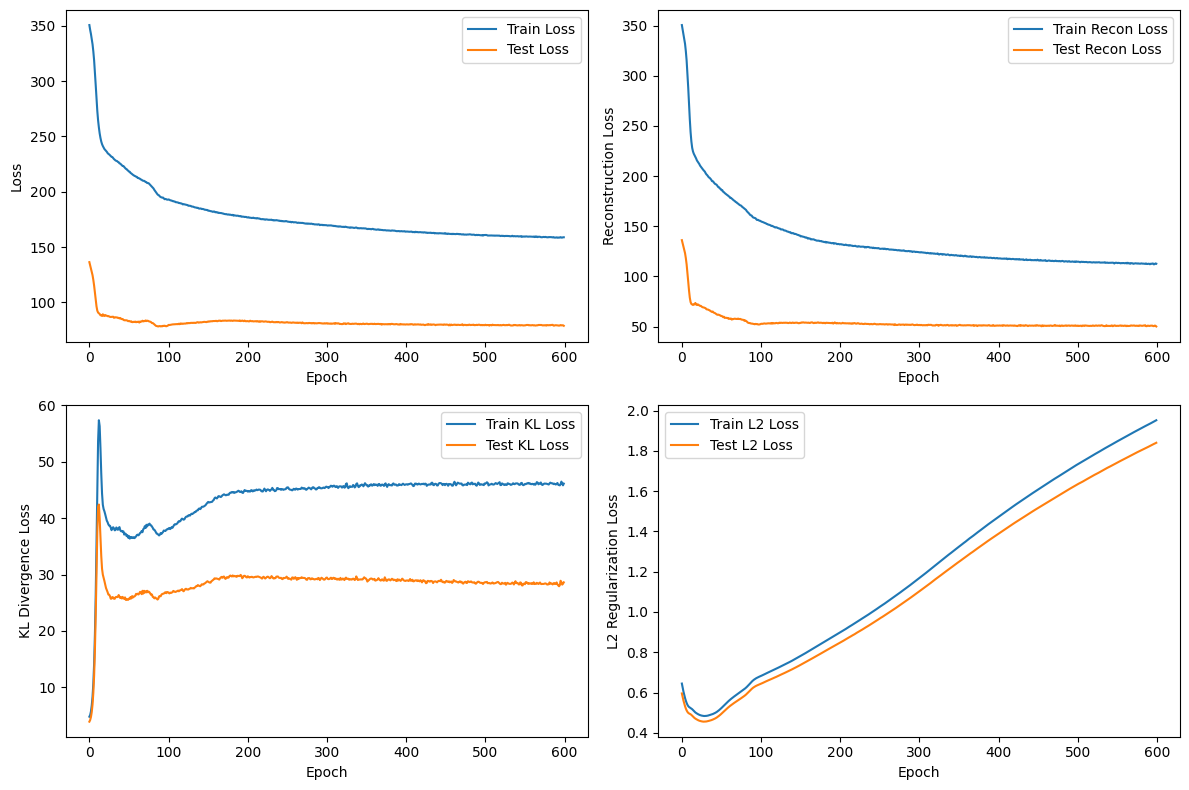

Epoch [610/1000], Train Loss: 158.4193, Train Recon Loss: 112.3632, Train KL Loss: 46.0541, Train L2 Loss: 1.9724, Test Loss: 79.2159, Test Recon Loss: 50.9941, Test KL Loss: 28.2199, Test L2 Loss: 1.8593
Epoch [620/1000], Train Loss: 158.1204, Train Recon Loss: 112.0063, Train KL Loss: 46.1121, Train L2 Loss: 1.9919, Test Loss: 79.2238, Test Recon Loss: 51.1046, Test KL Loss: 28.1174, Test L2 Loss: 1.8777
Epoch [630/1000], Train Loss: 158.1099, Train Recon Loss: 111.9007, Train KL Loss: 46.2072, Train L2 Loss: 2.0116, Test Loss: 79.0482, Test Recon Loss: 50.6820, Test KL Loss: 28.3643, Test L2 Loss: 1.8962
Epoch [640/1000], Train Loss: 157.8167, Train Recon Loss: 111.8410, Train KL Loss: 45.9737, Train L2 Loss: 2.0307, Test Loss: 79.4366, Test Recon Loss: 51.3239, Test KL Loss: 28.1108, Test L2 Loss: 1.9142
Epoch [650/1000], Train Loss: 157.5463, Train Recon Loss: 111.1970, Train KL Loss: 46.3473, Train L2 Loss: 2.0507, Test Loss: 79.2735, Test Recon Loss: 51.2093, Test KL Loss: 28.06

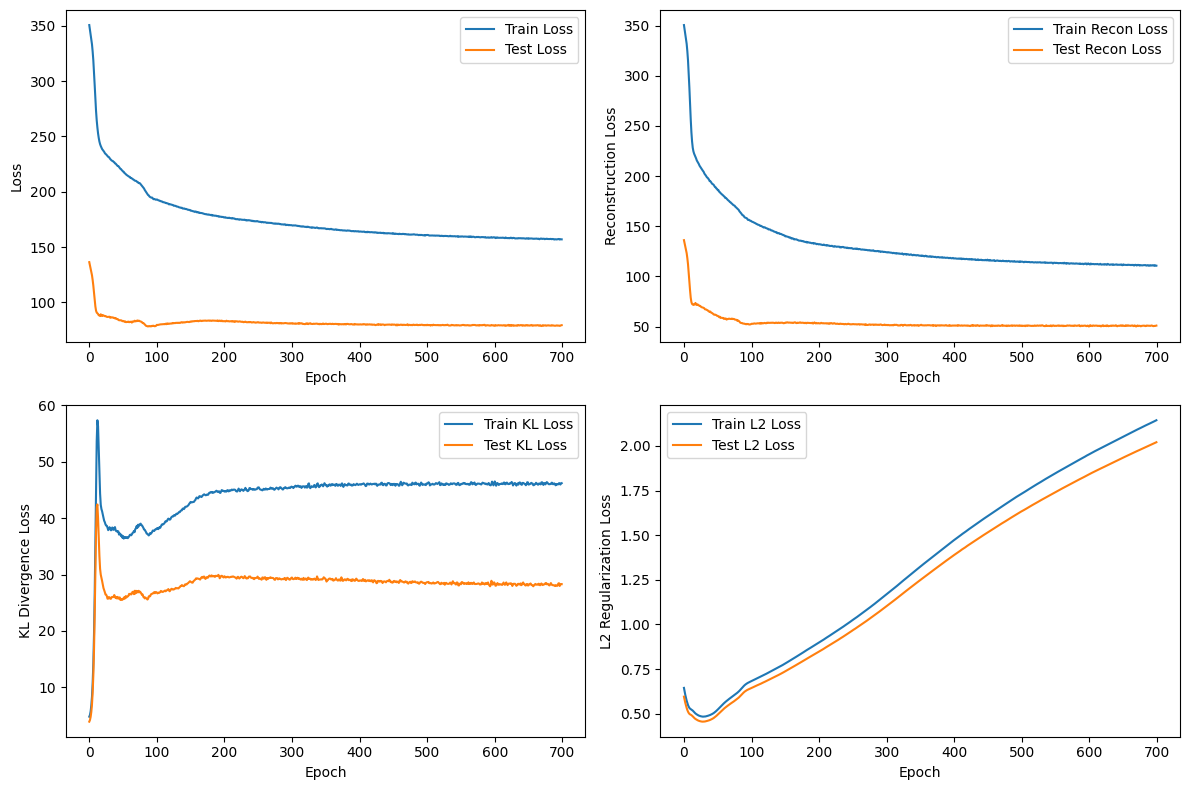

Epoch [710/1000], Train Loss: 156.8477, Train Recon Loss: 110.7937, Train KL Loss: 46.0518, Train L2 Loss: 2.1614, Test Loss: 79.0679, Test Recon Loss: 50.9530, Test KL Loss: 28.1129, Test L2 Loss: 2.0372
Epoch [720/1000], Train Loss: 156.3351, Train Recon Loss: 110.3989, Train KL Loss: 45.9340, Train L2 Loss: 2.1795, Test Loss: 78.8749, Test Recon Loss: 50.9001, Test KL Loss: 27.9728, Test L2 Loss: 2.0543
Epoch [730/1000], Train Loss: 156.7318, Train Recon Loss: 110.4416, Train KL Loss: 46.2880, Train L2 Loss: 2.1973, Test Loss: 78.9070, Test Recon Loss: 50.4150, Test KL Loss: 28.4899, Test L2 Loss: 2.0711
Epoch [740/1000], Train Loss: 156.6283, Train Recon Loss: 110.6714, Train KL Loss: 45.9546, Train L2 Loss: 2.2149, Test Loss: 79.1417, Test Recon Loss: 50.9599, Test KL Loss: 28.1797, Test L2 Loss: 2.0879
Epoch [750/1000], Train Loss: 156.2944, Train Recon Loss: 110.2282, Train KL Loss: 46.0640, Train L2 Loss: 2.2323, Test Loss: 78.6342, Test Recon Loss: 50.6509, Test KL Loss: 27.98

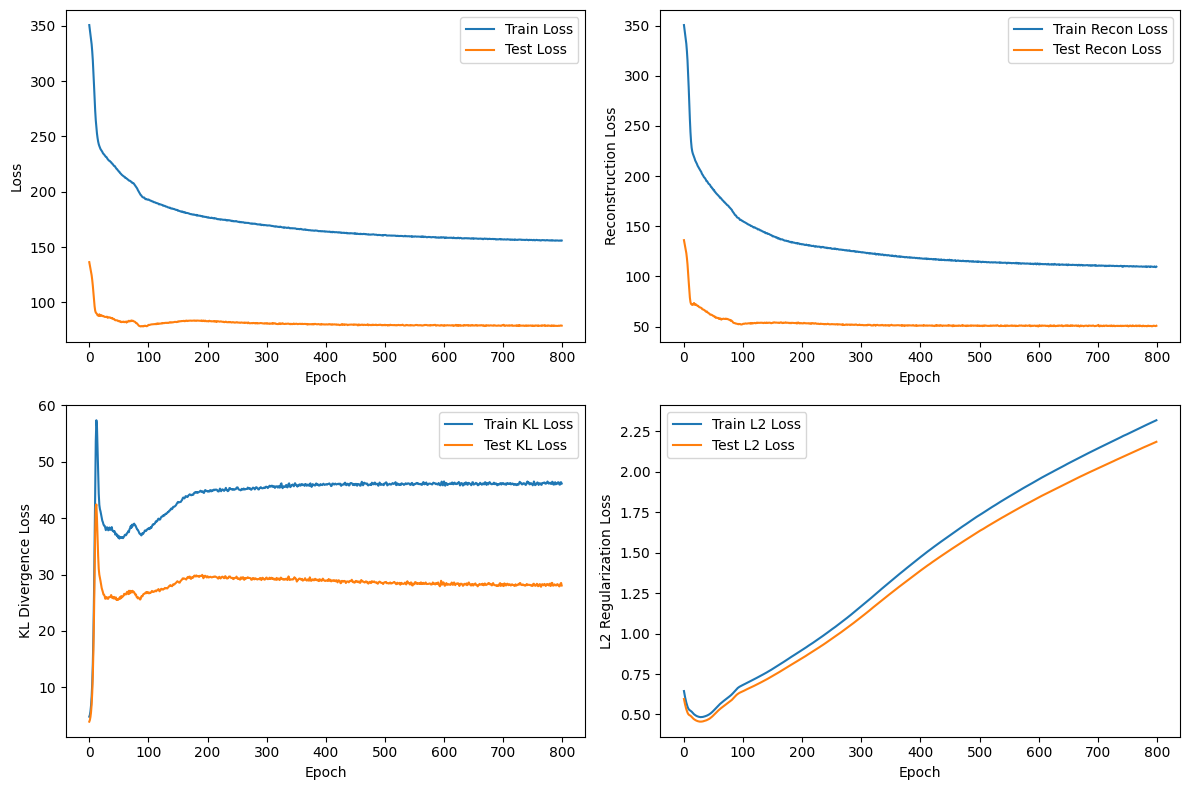

Epoch [810/1000], Train Loss: 155.5868, Train Recon Loss: 109.4157, Train KL Loss: 46.1688, Train L2 Loss: 2.3370, Test Loss: 78.8310, Test Recon Loss: 50.6714, Test KL Loss: 28.1575, Test L2 Loss: 2.2026
Epoch [820/1000], Train Loss: 155.5766, Train Recon Loss: 109.6197, Train KL Loss: 45.9546, Train L2 Loss: 2.3540, Test Loss: 78.7560, Test Recon Loss: 50.6368, Test KL Loss: 28.1170, Test L2 Loss: 2.2188
Epoch [830/1000], Train Loss: 155.5759, Train Recon Loss: 109.2971, Train KL Loss: 46.2764, Train L2 Loss: 2.3715, Test Loss: 78.6644, Test Recon Loss: 50.3765, Test KL Loss: 28.2857, Test L2 Loss: 2.2350
Epoch [840/1000], Train Loss: 155.3667, Train Recon Loss: 109.2132, Train KL Loss: 46.1511, Train L2 Loss: 2.3889, Test Loss: 78.8379, Test Recon Loss: 50.7161, Test KL Loss: 28.1196, Test L2 Loss: 2.2515
Epoch [850/1000], Train Loss: 155.2158, Train Recon Loss: 109.2916, Train KL Loss: 45.9218, Train L2 Loss: 2.4054, Test Loss: 79.1533, Test Recon Loss: 50.9709, Test KL Loss: 28.18

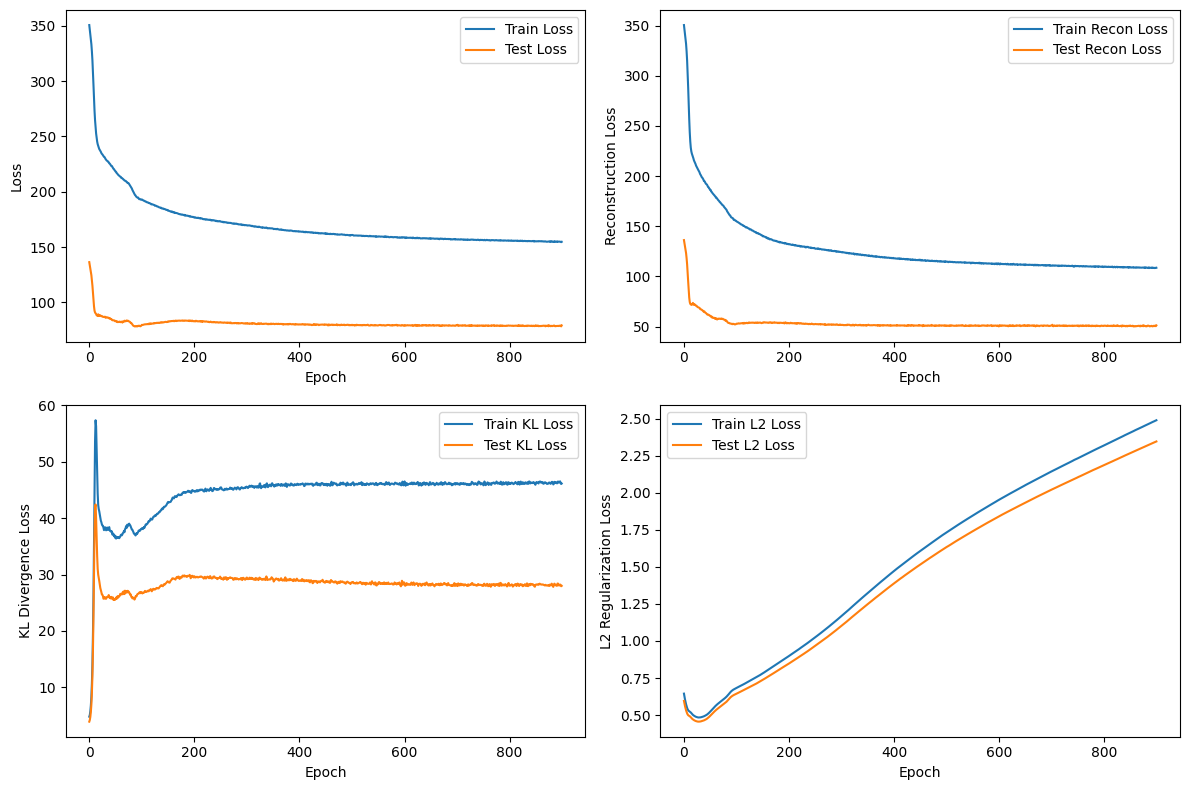

Epoch [910/1000], Train Loss: 154.6831, Train Recon Loss: 108.1881, Train KL Loss: 46.4924, Train L2 Loss: 2.5063, Test Loss: 78.8623, Test Recon Loss: 50.6203, Test KL Loss: 28.2396, Test L2 Loss: 2.3621
Epoch [920/1000], Train Loss: 154.6297, Train Recon Loss: 108.1888, Train KL Loss: 46.4384, Train L2 Loss: 2.5224, Test Loss: 78.4828, Test Recon Loss: 50.1386, Test KL Loss: 28.3419, Test L2 Loss: 2.3772
Epoch [930/1000], Train Loss: 154.3019, Train Recon Loss: 108.0736, Train KL Loss: 46.2258, Train L2 Loss: 2.5381, Test Loss: 78.6668, Test Recon Loss: 50.4996, Test KL Loss: 28.1648, Test L2 Loss: 2.3922
Epoch [940/1000], Train Loss: 154.3105, Train Recon Loss: 107.8122, Train KL Loss: 46.4957, Train L2 Loss: 2.5543, Test Loss: 78.2621, Test Recon Loss: 49.8437, Test KL Loss: 28.4160, Test L2 Loss: 2.4071
Epoch [950/1000], Train Loss: 154.2382, Train Recon Loss: 107.6674, Train KL Loss: 46.5682, Train L2 Loss: 2.5701, Test Loss: 78.5132, Test Recon Loss: 50.2304, Test KL Loss: 28.28

In [ ]:
import os

input_dim = data.shape[1]
latent_dim = 10
hidden_dim = 16
seq_length = 21
batch_size = 256
learning_rate = 0.001
epochs = 1000
beta_start = 0.0
beta_end = 1.0
beta_threshold = 100
lambda_reg = 0.001
save_interval = 100
plot_interval = 100
decay_rate = 0.96
decay_steps = 500

train_dataset, test_dataset = preprocess_data(data, seq_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TempVAE(input_dim, latent_dim, hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

save_dir = 'model_checkpoints'
os.makedirs(save_dir, exist_ok=True)

model.train()
train_losses = []
test_losses = []
train_recon_losses = []
test_recon_losses = []
train_kl_losses = []
test_kl_losses = []
train_l2_losses = []
test_l2_losses = []

for epoch in trange(1, epochs+1):
    if epoch > beta_threshold:
        beta = beta_end
    else:
        beta = beta_end * (1 - decay_rate ** (epoch))

    train_loss, train_recon_loss, train_kl_loss, train_l2_loss = train(model, train_loader, optimizer, beta, lambda_reg, device)
    test_loss, test_recon_loss, test_kl_loss, test_l2_loss = test(model, test_loader, beta, lambda_reg, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_recon_losses.append(train_recon_loss)
    test_recon_losses.append(test_recon_loss)
    train_kl_losses.append(train_kl_loss)
    test_kl_losses.append(test_kl_loss)
    train_l2_losses.append(train_l2_loss)
    test_l2_losses.append(test_l2_loss)

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Recon Loss: {train_recon_loss:.4f}, "
              f"Train KL Loss: {train_kl_loss:.4f}, "
              f"Train L2 Loss: {train_l2_loss:.4f}, "
              f"Test Loss: {test_loss:.4f}, "
              f"Test Recon Loss: {test_recon_loss:.4f}, "
              f"Test KL Loss: {test_kl_loss:.4f}, "
              f"Test L2 Loss: {test_l2_loss:.4f}")

    if epoch % save_interval == 0:
        torch.save(model.state_dict(), os.path.join(save_dir, f'model_epoch_{epoch}.pth'))

    if epoch % plot_interval == 0:
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(train_recon_losses, label='Train Recon Loss')
        plt.plot(test_recon_losses, label='Test Recon Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Reconstruction Loss')
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(train_kl_losses, label='Train KL Loss')
        plt.plot(test_kl_losses, label='Test KL Loss')
        plt.xlabel('Epoch')
        plt.ylabel('KL Divergence Loss')
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(train_l2_losses, label='Train L2 Loss')
        plt.plot(test_l2_losses, label='Test L2 Loss')
        plt.xlabel('Epoch')
        plt.ylabel('L2 Regularization Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    lr = learning_rate * (decay_rate ** (epoch // decay_steps))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Further training

In [ ]:
end_epoch = 500
model = TempVAE(input_dim, latent_dim, hidden_dim).to(device)
model.load_state_dict(torch.load('model_checkpoints/model_epoch_500.pth'))

for epoch in trange(500, epochs+1):
    if epoch < beta_threshold:
        beta = beta_start
    else:
        beta = beta_start + (beta_end - beta_start) * (epoch - beta_threshold) / (epochs - beta_threshold)

    train_loss, train_recon_loss, train_kl_loss, train_l2_loss = train(model, train_loader, optimizer, beta, lambda_reg, device)
    test_loss, test_recon_loss, test_kl_loss, test_l2_loss = test(model, test_loader, beta, lambda_reg, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_recon_losses.append(train_recon_loss)
    test_recon_losses.append(test_recon_loss)
    train_kl_losses.append(train_kl_loss)
    test_kl_losses.append(test_kl_loss)
    train_l2_losses.append(train_l2_loss)
    test_l2_losses.append(test_l2_loss)

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Recon Loss: {train_recon_loss:.4f}, "
              f"Train KL Loss: {train_kl_loss:.4f}, "
              f"Train L2 Loss: {train_l2_loss:.4f}, "
              f"Test Loss: {test_loss:.4f}, "
              f"Test Recon Loss: {test_recon_loss:.4f}, "
              f"Test KL Loss: {test_kl_loss:.4f}, "
              f"Test L2 Loss: {test_l2_loss:.4f}")

    if epoch % save_interval == 0:
        torch.save(model.state_dict(), os.path.join(save_dir, f'model_epoch_{epoch}.pth'))

    if epoch % plot_interval == 0:
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(train_recon_losses, label='Train Recon Loss')
        plt.plot(test_recon_losses, label='Test Recon Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Reconstruction Loss')
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(train_kl_losses, label='Train KL Loss')
        plt.plot(test_kl_losses, label='Test KL Loss')
        plt.xlabel('Epoch')
        plt.ylabel('KL Divergence Loss')
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(train_l2_losses, label='Train L2 Loss')
        plt.plot(test_l2_losses, label='Test L2 Loss')
        plt.xlabel('Epoch')
        plt.ylabel('L2 Regularization Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    # Learning rate decay
    lr = learning_rate * (decay_rate ** (epoch // decay_steps))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Final model

In [144]:
model = TempVAE(input_dim, latent_dim, hidden_dim).to(device)
model.load_state_dict(torch.load('model_checkpoints/model_epoch_100.pth'))

<All keys matched successfully>

# Testing dimentions

In [145]:
x = torch.rand(21, 1, 13).to(device)
print(model(x)[0].shape)

torch.Size([21, 1, 13])


In [146]:
mu_z = model(x)[1]
logvar_z = model(x)[2]
print(mu_z.shape, logvar_z.shape)

torch.Size([21, 1, 10]) torch.Size([21, 1, 10])


# VaR Forecasting

In [8]:
portfolio_weights = np.random.rand(data.shape[1])
portfolio_weights /= np.sum(portfolio_weights)
portfolio_weights = torch.tensor(portfolio_weights, dtype=torch.float32, device=device)
train_dataset, test_dataset = preprocess_data(data, seq_length)

In [165]:
def generate_var_forecast(model, sequence, weights, num_samples=1000, alpha=0.01, device=torch.device('cpu')):
    model.eval()
    with torch.no_grad():
        seq_len = sequence.size(0)
        sequence = sequence.unsqueeze(0).to(device)

        z_prev = torch.zeros(1, 1, model.latent_dim).to(device)

        for t in range(seq_len):
            x_t = sequence[:, t, :].unsqueeze(1)
            mu_z, logvar_z = model.encoder(x_t, z_prev)
            z_t = model.reparameterize(mu_z, logvar_z)
            z_prev = z_t.unsqueeze(1)

        z_prev = z_t

        portfolio_returns = []
        for _ in range(num_samples):
            prior_mu, prior_logvar = model.prior_network(z_prev.unsqueeze(1))
            z_next = model.reparameterize(prior_mu, prior_logvar)
            x_forecast = model.decoder(z_next.unsqueeze(1), 1)
            portfolio_return = torch.matmul(x_forecast.squeeze(1), weights).item()
            portfolio_returns.append(portfolio_return)

        var_forecast = np.percentile(portfolio_returns, alpha * 100)

    return var_forecast

var_forecast_one = generate_var_forecast(model, test_dataset[0][0], portfolio_weights, device=device)
print(var_forecast_one)

-1.747743046283722


In [156]:
torch.matmul((test_dataset[1][0]), portfolio_weights)[-1]

tensor(-1.6907)

In [125]:
def var_rolling_forecast(model, test_dataset, weights, seq_length=21, num_samples=1000, alpha=0.05, device=torch.device('cpu')):
    var_forecasts = []

    for i in trange(len(test_dataset) - seq_length + 1):
        sequence = test_dataset[i:i+seq_length]
        sequence = torch.cat([item[0] for item in sequence], dim=0)
        var_forecast = generate_var_forecast(model, sequence, weights, num_samples, alpha, device)
        var_forecasts.append(var_forecast)

    return np.array(var_forecasts)

var_forecasts = var_rolling_forecast(model, test_dataset, portfolio_weights)

  0%|          | 0/740 [00:00<?, ?it/s]

In [133]:
var_forecasts[:40]

array([-1.27834028, -1.24926998, -1.36016433, -1.3145119 , -1.2895914 ,
       -1.27995487, -1.21145042, -1.27022794, -1.2366299 , -1.17751459,
       -1.22094059, -1.30538957, -1.44598402, -1.27101033, -1.27125781,
       -1.31346399, -1.33653789, -1.27390947, -1.29271837, -1.20504415,
       -1.34362484, -1.21480362, -1.15063279, -1.3279394 , -1.24507825,
       -1.30716277, -1.21731719, -1.43617905, -1.21852368, -1.08744431,
       -1.24061098, -1.28061879, -1.36781247, -1.32512868, -1.22397168,
       -1.27859761, -1.30122334, -1.19336143, -1.27613745, -1.3413529 ])

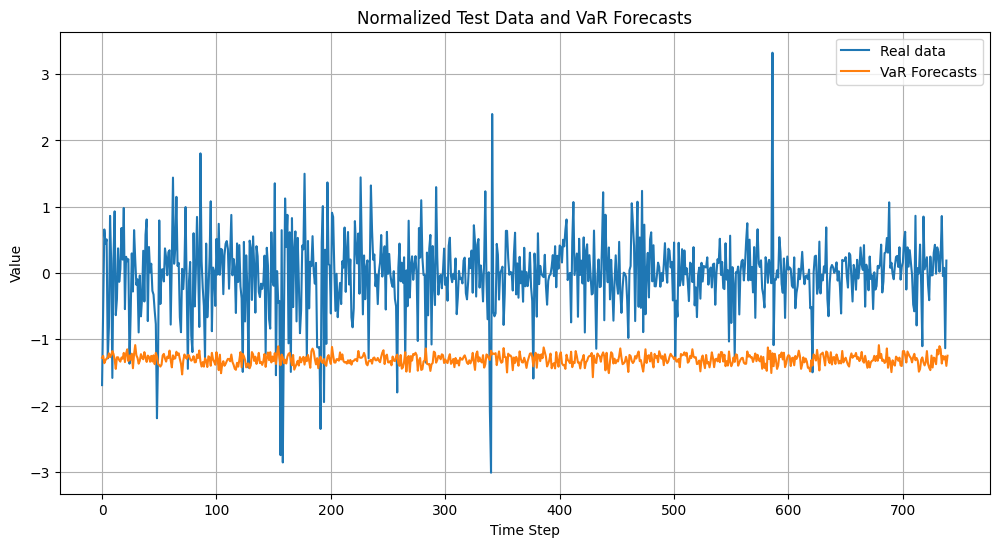

In [135]:
def extract_normalized_test_data(test_dataset):
    test_data = []
    for sequence in test_dataset:
        test_data.append(sequence[0][0][:].numpy())
    return np.array(test_data)

normalized_test_data = extract_normalized_test_data(test_dataset)
portfolio = torch.tensor(normalized_test_data, dtype=torch.float32, device=device)
portfolio = torch.matmul(portfolio, portfolio_weights)

plt.figure(figsize=(12, 6))
plt.plot(portfolio[seq_length:], label='Real data')
# plt.plot(portfolio[seq_length - 1:][:40], label='One step back data')
plt.plot(var_forecasts, label='VaR Forecasts')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Normalized Test Data and VaR Forecasts')
plt.legend()
plt.grid(True)
plt.show()